# Testing EUGENE model interpretation

**Authorship:**
Adam Klie, *03/19/2022*
***
**Description:**
Notebook for testing predictions with EUGENE architectures

<div class="alert alert-block alert-warning">
<b>TODOs</b>:
<ul>
    <b><li>Troubleshoot convs</li></b>
    </ul>
</div>

In [515]:
import os
import tqdm
import numpy as np
import pandas as pd
import matplotlib as mpl

# Torch
import torch
import torch.nn.functional as F

# Viz
import logomaker as lm
import seqlogo

# PL and EUGENE
from pytorch_lightning.utilities.cli import LightningArgumentParser
from pytorch_lightning import Trainer
from eugene.dataloading.SeqDataModule import SeqDataModule
from eugene.models.hybrid import hybrid
from eugene.utils.seq_utils import one_hot_to_dna

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

# Interpretation of a EUGENE model using a PWM strategy
<div class="alert alert-info" role="alert">
  <b>PWM module for intepretation of a EUGENE model</b>
</div>

# Load data

In [516]:
parser = LightningArgumentParser()
parser.add_lightning_class_args(Trainer, nested_key="trainer")
parser.add_lightning_class_args(SeqDataModule, nested_key="data")
parser.add_lightning_class_args(hybrid, nested_key="model");

In [648]:
data_config = "/cellar/users/aklie/projects/EUGENE/config/data/2021_OLS_Library_Training_OHE-T_reg_train.yaml"
data_yml = parser.parse_path(cfg_path=data_config)
mod = SeqDataModule(**data_yml["data"])

In [649]:
CKT_PTH  = "/cellar/users/aklie/projects/EUGENE/results/benchmark/benchmark2/reg/sshybrid/2022_05_14_OHE_Full_Test/checkpoints/epoch=24-step=10124.ckpt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
eugene = hybrid.load_from_checkpoint(
    checkpoint_path=CKT_PTH,
    map_location=device,
)

# PWM-ify the 1st CNN Layer

## Get the activations of data passed through the layer

In [650]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [651]:
# Grab it and also try registering it as a forward hook (https://discuss.pytorch.org/t/how-can-i-extract-intermediate-layer-output-from-loaded-cnn-model/77301/2)
first_layer = eugene.convnet.module[0]
eugene.convnet.module[0].register_forward_hook(get_activation(0))

In [652]:
# Grab the val dataloader
mod.setup()
dataloader = mod.val_dataloader()

## Quick test of different strategies

In [653]:
# Just grab the first batch for now
for i_batch, batch in tqdm.tqdm(enumerate(dataloader)):
    ID, x, x_rev_comp, y = batch
    break

0it [00:00, ?it/s]


In [654]:
# Pass through the model, necessary to get that forward hook
output = eugene(x, x_rev_comp)

In [655]:
# Looks like the first one has Relu already computed on it
activation[0][0][0], first_layer(x)[0][0].detach()

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0294, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0354,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.2397, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.1811, 0.0000, 0.0000]),
 tensor([-0.1861, -1.1977, -0.0889, -0.2809, -0.2555, -1.2589, -0.7527, -1.0241,
         -0.1896, -0.4077, -0.4301, -0.8661, -0.2607, -0.0230, -0.4992, -0.9090,
         -0.8255, -0.8189,  0.0294, -0.2487, -0.4591, -0.6207, -0.7830, -0.2642,
         -0.6968, -0.1376,  0.0354, -0.2046, -0.5400, -0.7577, -0.1533, -0.3294,
         -0.0454, -0.4118, -0.2923, -0.7059,  0.2397, -0.5327, -0.5613, -2.0968,
         -0.6675, -0.4510, -0.2353, -0.4614, -0.5774, -1.0587, -1.1953, -0.6095,
         -0.6805,  0.1811, -0.4103, -0.496

In [656]:
torch.all(torch.isclose(activation[0][0][0], first_layer(x)[0][0].detach()))

tensor(True)

In [657]:
# Grab all the activations
activations = []
sequences = []
for i_batch, batch in tqdm.tqdm(enumerate(dataloader)):
    ID, x, x_rev_comp, y = batch
    #output = eugene(x, x_rev_comp)
    #activations.append(activation[0])
    sequences.append(np.array([one_hot_to_dna(sequence.transpose(1,0)) for sequence in x]))
    activations.append(F.relu(first_layer(x)).detach().numpy())

45it [00:03, 15.00it/s]


In [658]:
# Concatenate the batches together
np_act = np.concatenate(activations)
np_seq = np.concatenate(sequences)
np_act.shape, np_seq.shape

((46080, 32, 52), (46080,))

In [659]:
# Activations of filter 1 for sequence 1 after relu
np_act[0][0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02939141, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03535811, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.2396881 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.18112607,
       0.        , 0.        ], dtype=float32)

In [660]:
max_val

0.7185637

In [661]:
np.sum(single_filter > max_val/2)

3196

In [662]:
np_seq[i][start:start+first_layer.kernel_size[0]]

'AAGCTCAGATATTTG'

In [663]:
kernel_size = first_layer.kernel_size[0]

In [664]:
# Grab sequences that activate the filter
filter_activators = []
for filt in range(np_act.shape[1]):
    single_filter = np_act[:, filt, :]
    max_val = np.max(single_filter)
    activators = []
    for i in range(len(single_filter)):
        starts = np.where(single_filter[i] > max_val/2)[0]
        for start in starts:
            activators.append(np_seq[i][start:start+kernel_size])
    print(filt, ": ", len(activators), max_val)
    filter_activators.append(activators)
len(filter_activators)

0 :  27078 0.98293257
1 :  24459 0.9244621
2 :  27518 0.98589003
3 :  29774 0.96785784
4 :  22630 0.8265096
5 :  14481 0.95244104
6 :  38448 0.8423619
7 :  16138 0.72450805
8 :  18695 0.9782884
9 :  21986 1.1282506
10 :  50046 1.0021834
11 :  25971 0.79824203
12 :  9084 0.8078044
13 :  33092 0.81428164
14 :  15263 0.504656
15 :  46633 0.8309151
16 :  14918 0.9239185
17 :  34854 0.8381037
18 :  50211 0.9162774
19 :  13144 0.642018
20 :  27747 1.0053785
21 :  23013 1.0769199
22 :  6524 1.1790497
23 :  31812 0.64548135
24 :  34573 0.6170426
25 :  24702 1.1089623
26 :  48052 0.9654118
27 :  26374 1.0293001
28 :  34186 0.662949
29 :  33682 0.99294126
30 :  13489 0.6192548
31 :  35281 0.9096071


32

In [665]:
from eugene.utils.seq_utils import ohe

In [666]:
test_seq = torch.tensor(ohe(np_seq[i]).T).float()

In [667]:
F.relu(first_layer(test_seq))[filt], single_filter[i]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.2964, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.3011, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0434, 0.0000, 0.0000, 0.0115, 0.0000,
         0.0000, 0.0000, 0.1194, 0.0000, 0.0000, 0.6002, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.1882, 0.0000, 0.0645, 0.0000, 0.0436,
         0.0000, 0.2372, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        grad_fn=<SelectBackward0>),
 array([0.        , 0.        , 0.        , 0.        , 0.2964497 ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.301076  , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.04343328, 0.        , 0.        ,
        0.01152616, 0.        , 0.        , 0.        , 0.11942857,
        0.        , 0.        , 0.6002161 , 0.        , 0.        ,
        0.       

0it [00:00, ?it/s]

Filter 0:  TTACGCTCACTACCG


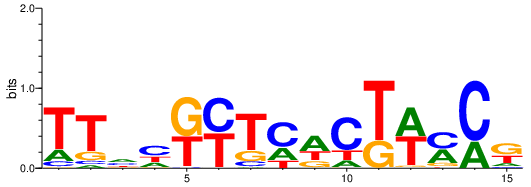

1it [00:00,  1.15it/s]

Filter 1:  ACTTCCGAAGTTCAC


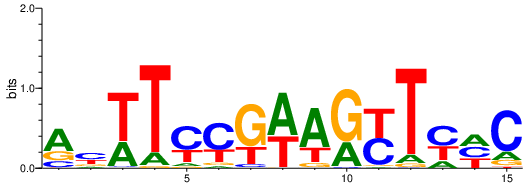

2it [00:01,  1.20it/s]

Filter 2:  TATCTTAGCAGATAT


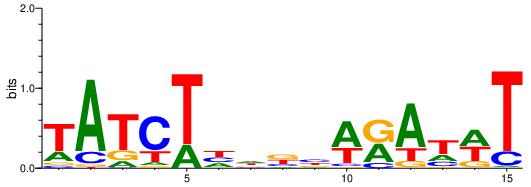

3it [00:02,  1.18it/s]

Filter 3:  AACGGAAGTTCGTTA


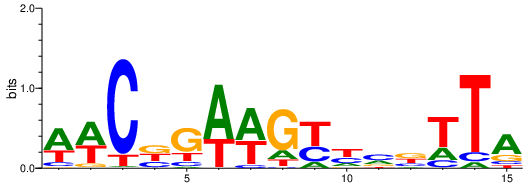

4it [00:03,  1.17it/s]

Filter 4:  CTTATGGAAGTTCTC


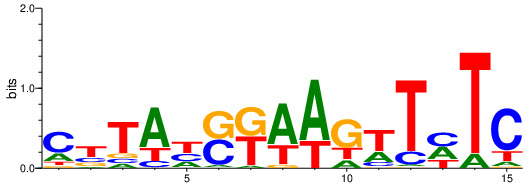

5it [00:04,  1.13it/s]

Filter 5:  CGTTAATGGAAAAGG


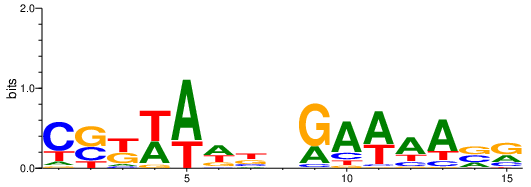

6it [00:05,  1.10it/s]

Filter 6:  TCTTAATCTCACACA


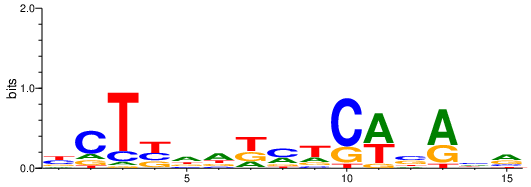

7it [00:06,  1.01it/s]

Filter 7:  CTTACTTTATCTGAA


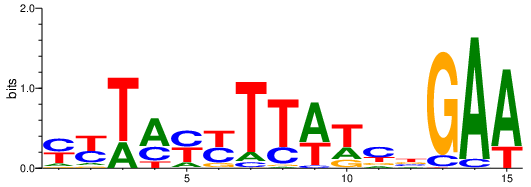

8it [00:07,  1.02it/s]

Filter 8:  TCCCTATGATAAACA


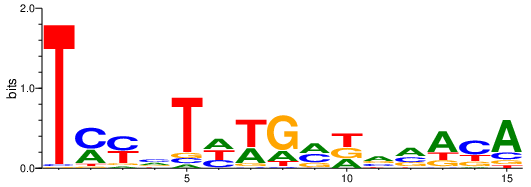

9it [00:08,  1.06it/s]

Filter 9:  CGTTATCTTTATCGG


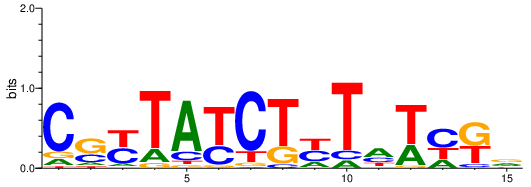

10it [00:09,  1.04it/s]

Filter 10:  AAGGAAATCTTTCGT


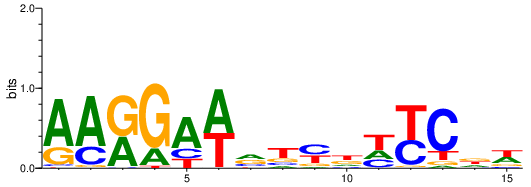

11it [00:10,  1.04s/it]

Filter 11:  ATAATTACTTACTTT


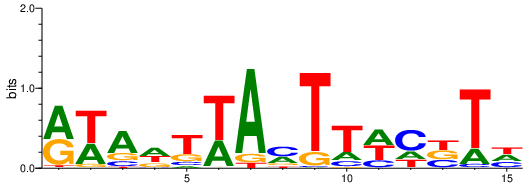

12it [00:11,  1.04s/it]

Filter 12:  GATAACTTCGATATA


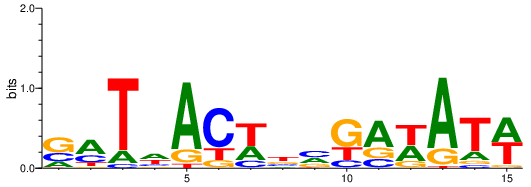

13it [00:12,  1.00it/s]

Filter 13:  TTATCGAAAACGTAA


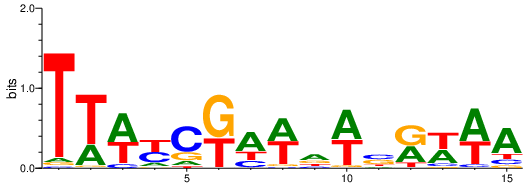

14it [00:13,  1.02s/it]

Filter 14:  CCGTTTCCGATATCT


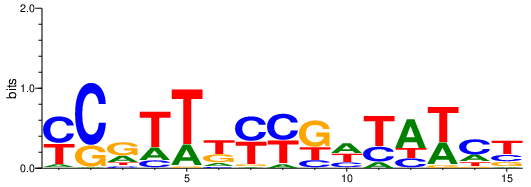

15it [00:14,  1.00s/it]

Filter 15:  CTGAATCTCATTTCT


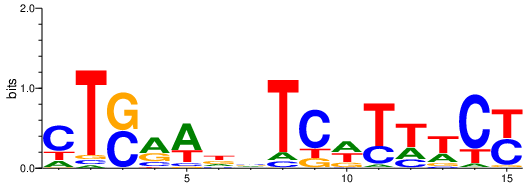

16it [00:15,  1.09s/it]

Filter 16:  GATTTGCTCATCTTC


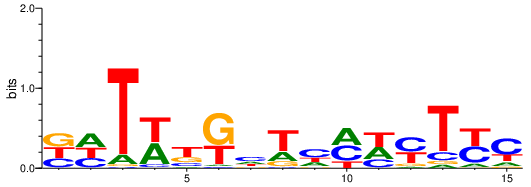

17it [00:16,  1.09s/it]

Filter 17:  GTTTTCGAAAATGGA


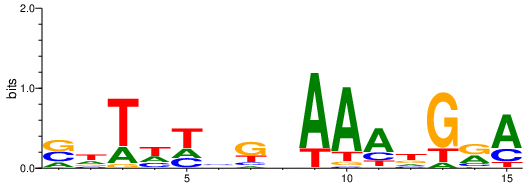

18it [00:18,  1.13s/it]

Filter 18:  GGAATTTGTAGTTAC


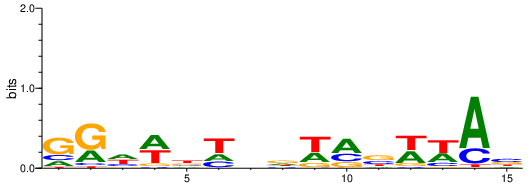

19it [00:19,  1.16s/it]

Filter 19:  AGTTAATTTCCAAAT


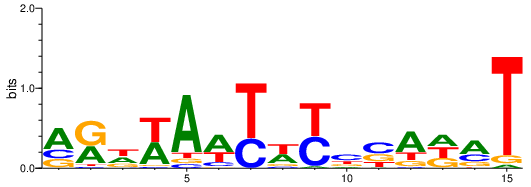

20it [00:20,  1.10s/it]

Filter 20:  ATAACCATCTGAAGC


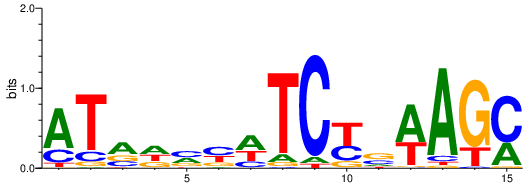

21it [00:21,  1.12s/it]

Filter 21:  AAGTTAACTATATCT


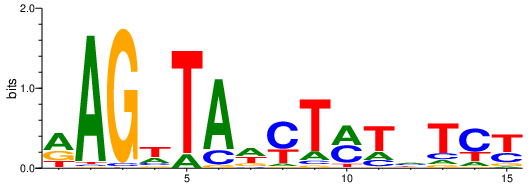

22it [00:22,  1.13s/it]

Filter 22:  AAATAACGAAAGTAA


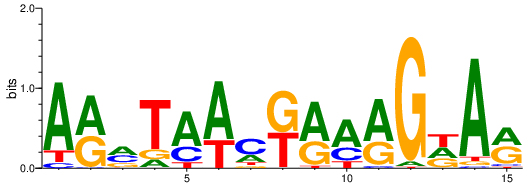

23it [00:23,  1.04s/it]

Filter 23:  TTTCGAAATTATCTC


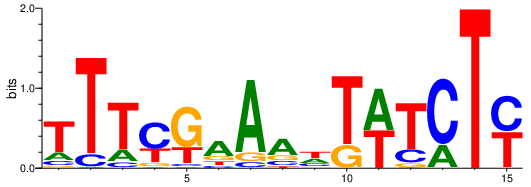

24it [00:24,  1.04s/it]

Filter 24:  TTATTACCTTTTCCC


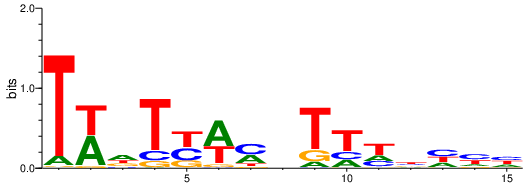

25it [00:25,  1.07s/it]

Filter 25:  CTGAAGTTCACGGAA


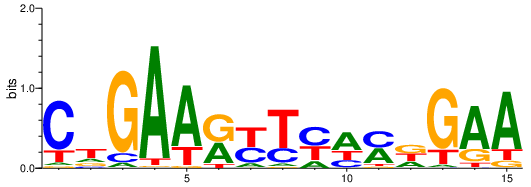

26it [00:26,  1.05s/it]

Filter 26:  TCCTAGATATAATAT


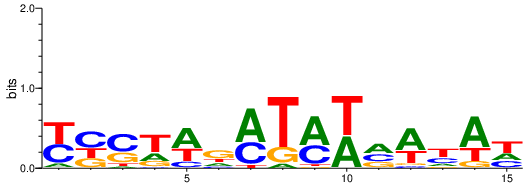

27it [00:27,  1.09s/it]

Filter 27:  GATATCCGTGCTCAA


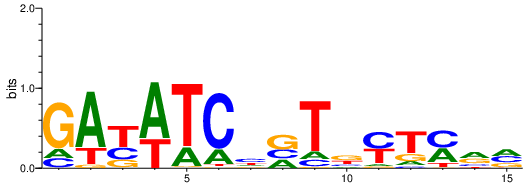

28it [00:28,  1.08s/it]

Filter 28:  CTGAAGCTCAATTTC


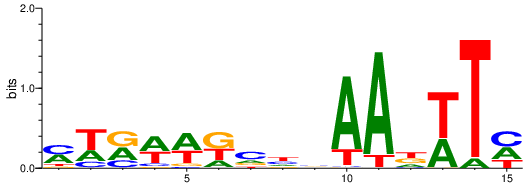

29it [00:29,  1.10s/it]

Filter 29:  CTCAAGATAATTTGC


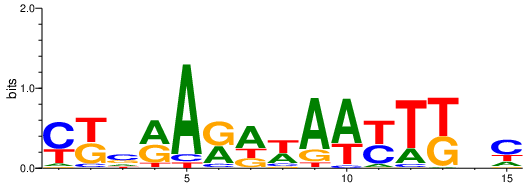

30it [00:31,  1.14s/it]

Filter 30:  ATTTTTCGAAAGTAA


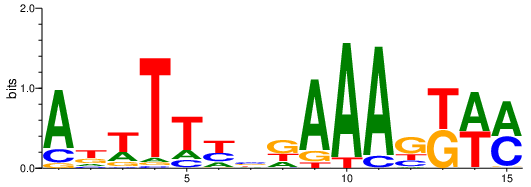

31it [00:32,  1.11s/it]

Filter 31:  TCTATATCTCGATAT


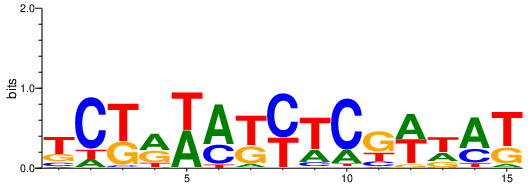

32it [00:33,  1.04s/it]


In [668]:
filter_pfms = {}
for i, activators in tqdm.tqdm(enumerate(filter_activators)):
    pfm = {"A": np.zeros(kernel_size), "C": np.zeros(kernel_size), "G": np.zeros(kernel_size), "T": np.zeros(kernel_size)}
    for seq in activators:
        for j, nt in enumerate(seq):
            pfm[nt][j]+=1
    filter_pfm = pd.DataFrame(pfm)
    filter_pfms[i] = filter_pfm
    cpm = seqlogo.CompletePm(pfm = filter_pfm)
    logo = seqlogo.seqlogo(cpm, ic_scale = True, format = 'png', size = 'medium')
    print(f"Filter {i}: ", cpm.consensus)
    display(logo)

In [ ]:
np.savetxt(f"test_OLSLibraryseqs_66/filter{filter_num}_activators.txt", activators, fmt="%s")

# Scratch

In [441]:
def pwm(freq, total, bg=0.25):
  #using the formulae above
  p = (freq + (np.sqrt(total) * 1/4)) / (total + (4 * (np.sqrt(total) * 1/4)))
  return np.log2(p/bg)

In [337]:
norm_filter1 = filter1_pfm/filter_pfm.sum(axis=1)[0]

In [338]:
norm_fiter1_t = norm_filter1.T

In [339]:
norm_fiter1_t

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
A,0.252105,0.314093,0.244615,0.324598,0.284512,0.268545,0.303436,0.248767,0.322901,0.252683,0.283279,0.320673,0.280605,0.354227,0.271010
C,0.248881,0.194023,0.279809,0.191691,0.226032,0.274177,0.166357,0.297785,0.186960,0.242387,0.265815,0.174226,0.263046,0.176473,0.198290
G,0.176862,0.185642,0.165143,0.178133,0.180465,0.163380,0.176369,0.168443,0.133173,0.190477,0.154572,0.161484,0.187007,0.117662,0.203741
T,0.322152,0.306242,0.310433,0.305579,0.308992,0.293898,0.353838,0.285005,0.356967,0.314453,0.296335,0.343617,0.269342,0.351638,0.326959


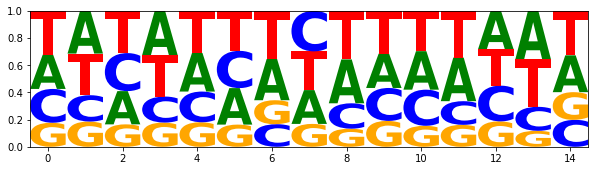

In [350]:
for pwm in pwms:
    pwm_df = norm_fiter1_t.T
    lm.Logo(pwm_df)
    break

In [341]:
np.unique(activators)

array(['AAAAGGAAATAAGAT', 'AAAAGGAAATAATAT', 'AAAAGGAAATAGATA',
       'AAAAGGAAATCCTAT', 'AAAAGGAAATTGCTC', 'AAACGGAAGTAAGGA',
       'AAACGGAAGTATTTC', 'AAACGGAAGTCATCT', 'AAACGGAAGTTAAAG',
       'AAACGGAAGTTAATT', 'AAACGGAAGTTGCTC', 'AAACTTCCGTAAGGA',
       'AAACTTCCGTATTTC', 'AAACTTCCGTCATCT', 'AAACTTCCGTTAAAG',
       'AAACTTCCGTTAATT', 'AAACTTCCGTTGCTC', 'AAAGGAAATAATATC',
       'AAAGGAAATAGATAT', 'AAAGGAAATCATCTG', 'AAAGGAAATTAAATA',
       'AAAGGAAATTAAGAT', 'AAAGGAAATTGCTCA', 'AAAGGAAATTTTCGA',
       'AAATAATATCTCATC', 'AAATAGATATTCATC', 'AAATATCTCATCTGA',
       'AAATATCTTAAAGAT', 'AAATATCTTACCTAT', 'AAATCATCTGAAGCT',
       'AAATTAAATATCTCA', 'AAATTAAATATCTTT', 'AAATTAAGATATTCA',
       'AAATTAAGATATTTT', 'AAATTGCTCAAGATA', 'AAATTGCTCAATATC',
       'AAATTGCTCAGATAT', 'AAATTGCTCCCTATC', 'AAATTTCCTTAAGAT',
       'AAATTTCCTTAATAT', 'AAATTTCCTTAGATA', 'AAATTTCCTTCCTAT',
       'AAATTTCCTTTGCTC', 'AAATTTTCGAAAAGA', 'AAATTTTCGAAAATA',
       'AAATTTTCGAAAGAT', 'AAATTTTCGAACC

In [189]:
max_val = np.max(single_filter)
single_seq_activation = single_filter[0]
start = np.where(single_seq_activation > max_val/2)[0][0]
sequences[0][start:start+15]

'TATCTCTAACGGAAG'

In [159]:
np.where(single_filter > max_val/2)

(array([   0,    2,    3, ..., 9213, 9214, 9215]),
 array([14, 14, 14, ..., 39, 39, 39]))

In [149]:
np.max(np_act, axis=1)

TypeError: _amax_dispatcher() missing 1 required positional argument: 'a'

In [147]:
np_act[0][0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.06085813, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.55842197,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.12824464, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.1198988 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ], dtype=float32)

In [144]:
for i in range(66-15+1):
    print(np.multiply(x[0][:, i:i+15].detach(), pwm.detach()).sum())

tensor(-0.4553)
tensor(-0.5573)
tensor(-0.7340)
tensor(-0.1027)
tensor(-0.5635)
tensor(-0.2622)
tensor(-0.9945)
tensor(-0.9464)
tensor(-0.1164)
tensor(0.3529)
tensor(-0.5235)
tensor(-0.5887)
tensor(-0.9116)
tensor(-0.2790)
tensor(-0.5649)
tensor(-0.2392)
tensor(-0.8323)
tensor(-0.4968)
tensor(-1.4188)
tensor(0.0563)
tensor(-0.3540)
tensor(-0.6272)
tensor(-1.3250)
tensor(-0.5079)
tensor(-0.7727)
tensor(0.1844)
tensor(-0.5831)
tensor(-0.8570)
tensor(-1.2193)
tensor(-0.2764)
tensor(0.0126)
tensor(-0.4772)
tensor(-0.9501)
tensor(-0.1246)
tensor(-0.8577)
tensor(0.0183)
tensor(-0.6632)
tensor(-0.3511)
tensor(-0.5961)
tensor(-0.1275)
tensor(-0.9092)
tensor(-0.1598)
tensor(-0.3231)
tensor(-0.3099)
tensor(-1.0943)
tensor(-0.7591)
tensor(-0.6971)
tensor(0.0444)
tensor(-0.4752)
tensor(-0.7139)
tensor(-0.8136)
tensor(-0.7869)


# References